<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# Importing header files in one go

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

# For ease assign it to variable df
df = house

In [3]:
# Basic features of data and study the file.

df.shape #(1460, 81) 81 columns is a huge list of features.
df.columns # Puth these in an excel sheet and write which variable needs cleaning and is imprtant.
df.head()
len(df.describe().columns) # Only 38 features are originally numeric

38

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Check the rows which are not residential,take count and drop these.

#Equivalent to IN clause in SQL returns 1450 rows as compared to 1460 in original 
residential = ['FV','RH','RL','RP','RM']
df[df['MSZoning'].isin(residential)] 

# Update df to dropped rows data frame
df = df[df['MSZoning'].isin(residential)] 

df.shape # updated to (1450, 81) from 1460 rows
df[['1stFlrSF','GarageArea','GrLivArea','OverallQual']].isnull().sum() # Check if there are nulls

1stFlrSF       0
GarageArea     0
GrLivArea      0
OverallQual    0
dtype: int64

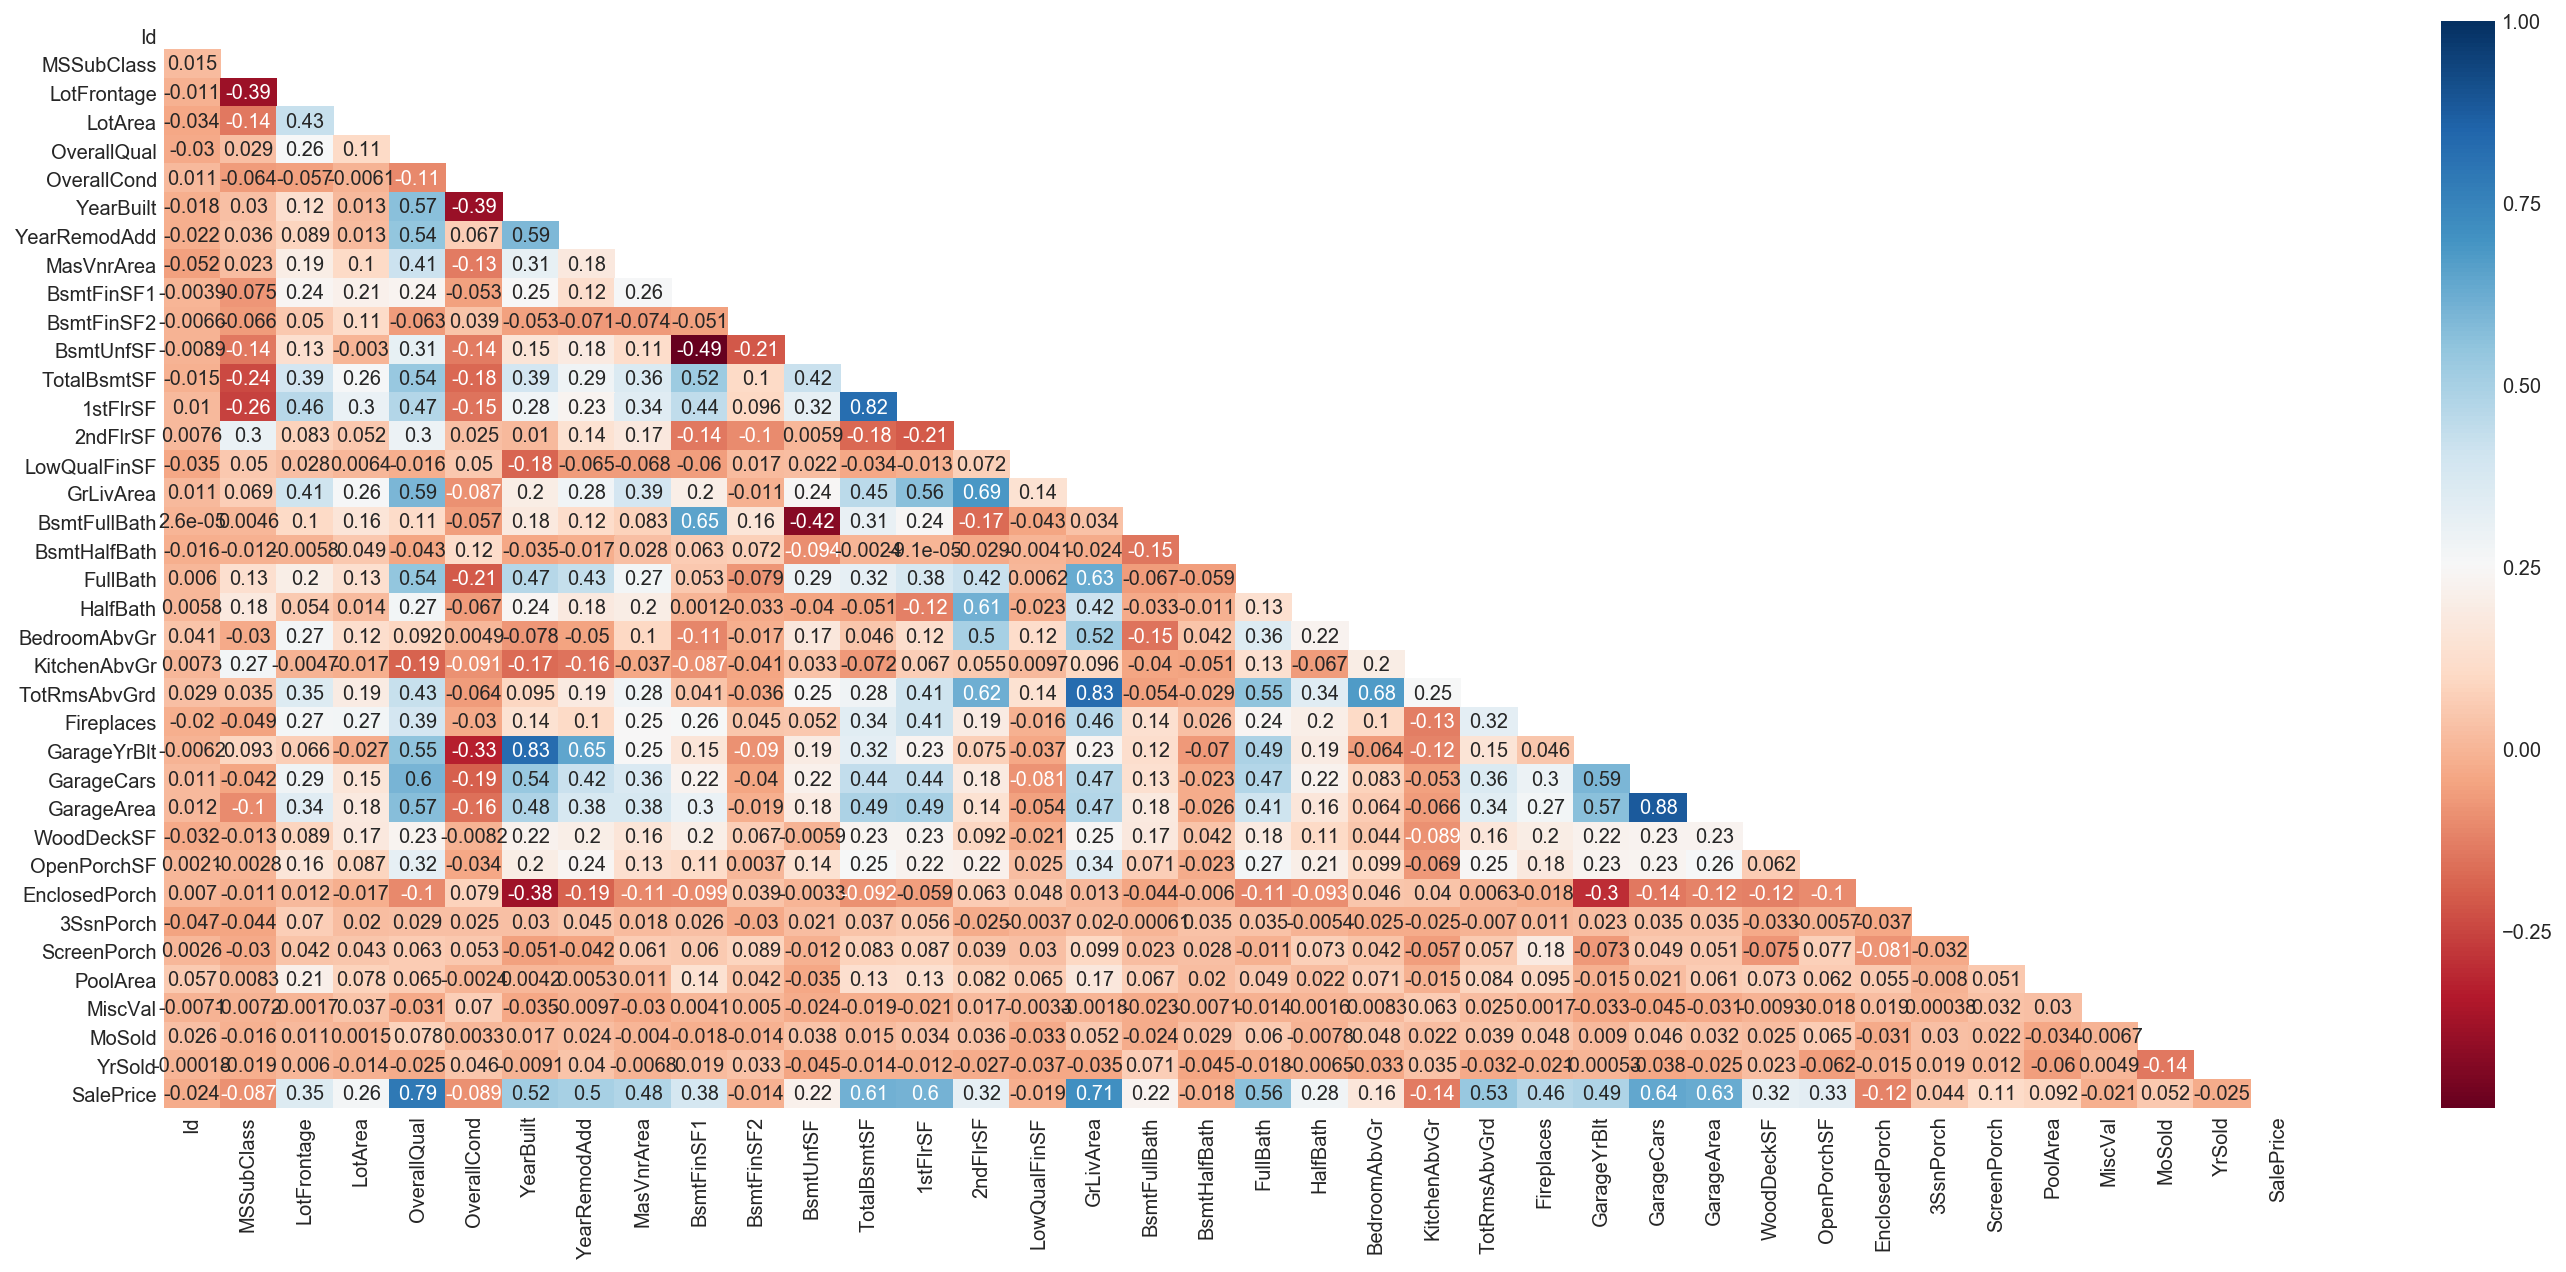

In [6]:
# To start with I used an approach suggested by Dayanad that take the correlation matrix of SalePrice
# with all numberic variables, without dropping or converting anything from data frame.
# I name it as a BUTCHER APPROACH.
df.corr() # Returns a 38 by 38 matrix

#All Copied from Seaborn documentation
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 10))

#Draw heatmap
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='RdBu', square=False)

# See the last row in heat map which is SalePrice and the noteable corellations are:
# OverallQual 
# TotalBsmtSF
# 1stFlrSF
# GrLivArea
# GarageCars
# GarageArea 


In [6]:
# Taking correlation a step further we will take correaltion only with SalePrice

# Assigning value to a variable so that we can directly put condition 
a = df.corr()['SalePrice'].sort_values() 

# Significant positive correlation values are >= .60 or significant negative correlation <= -.60 
a[(a>=.60) | (a<=-.60)]

# Values from above are following.
# 1stFlrSF       0.605852
# TotalBsmtSF    0.613581
# GarageArea     0.623431
# GarageCars     0.640409
# GrLivArea      0.708624
# OverallQual    0.790982

# Comparing output with previous step (done from manual eyeballing on heatmap) shows the same result.
# Realized this after comparing sorted outputs in excel.

1stFlrSF       0.603300
TotalBsmtSF    0.612088
GarageArea     0.629831
GarageCars     0.642135
GrLivArea      0.708658
OverallQual    0.789031
SalePrice      1.000000
Name: SalePrice, dtype: float64

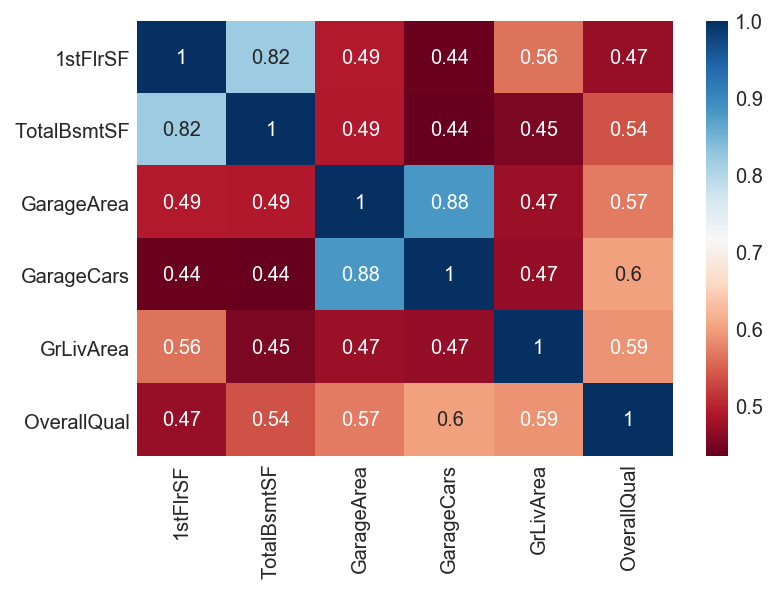

In [8]:
# To check multi collinear-ity within featurs I used heat map of reduced features.
# It shown that TotalBsmtSF and 1stFlrSF are collinear so i will take only later.
# It shown that GarageArea and GarageCars are collinear so I will take only first
# It also shows that other variables are independent of each other as most values are less than 0.6
# Suggested by Dayanand
X = df[['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars','GrLivArea','OverallQual']]
X.corr()
sns.heatmap(X.corr(),annot=True,cmap='RdBu')
# Dropping features from X (input)  mentioned in above comments
X = df[['1stFlrSF','GarageArea','GrLivArea','OverallQual']]

In [77]:
# MLR code copied 
X = df[['1stFlrSF','GarageArea','GrLivArea','OverallQual']] # Reduced features
y = df['SalePrice'] #Output variable what we want to predict

from sklearn.linear_model import LinearRegression # This is for linear regression
from sklearn.preprocessing import StandardScaler # This is for standardization

linreg = LinearRegression()
ss = StandardScaler() # Missed the method brackets and got errors
Xstd = ss.fit_transform(X) # Assigning standardized matrix to variable Xstd

# Fitting a Liner model on X without standardization
linreg.fit(X,y)  
yhat = linreg.predict(X)
linreg.score(X,y)
print ('Original matrix score is : ', linreg.score(X,y))

# Fitting a Liner model on X with standardization
linreg.fit(Xstd,y)  
yhat = linreg.predict(Xstd)
linreg.score(Xstd,y)
print ('Standard matrix score is : ', linreg.score(Xstd,y))

# Both scores are same but standardization is better computationaly

('Original matrix score is : ', 0.75210496519375358)
('Standard matrix score is : ', 0.75210496519375358)


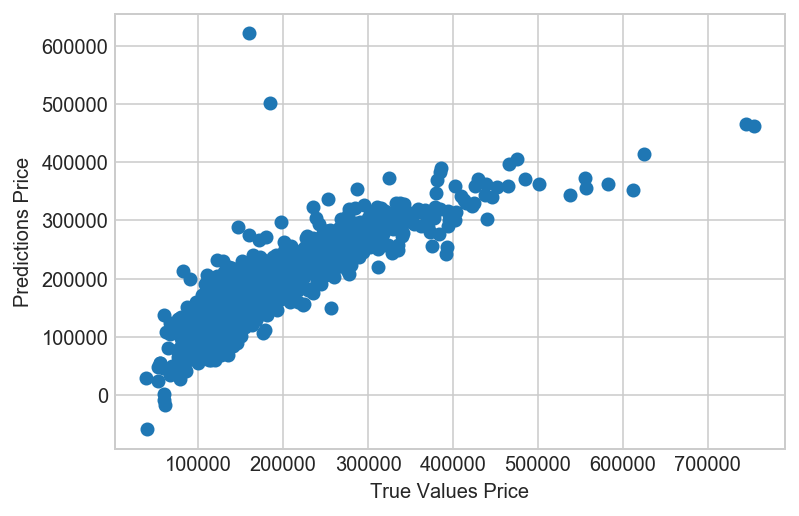

In [78]:
# Plotting original price and predicted price on X and Y axis of plot.
plt.scatter(y, yhat)
plt.xlabel("True Values Price")
plt.ylabel("Predictions Price")

In [80]:
# MLR after removing renovatable feature which is OverallQual
X = df[['1stFlrSF','GarageArea','GrLivArea']] # Reduced features
y = df['SalePrice'] #Output variable what we want to predict

from sklearn.linear_model import LinearRegression # This is for linear regression
from sklearn.preprocessing import StandardScaler # This is for standardization

linreg = LinearRegression()
ss = StandardScaler() # Missed the method brackets and got errors
Xstd = ss.fit_transform(X) # Assigning standardized matrix to variable Xstd

# Fitting a Liner model on X without standardization
linreg.fit(X,y)  
yhat = linreg.predict(X)
linreg.score(X,y)
print ('Original matrix score is : ', linreg.score(X,y))

# Fitting a Liner model on X with standardization
linreg.fit(Xstd,y)  
yhat = linreg.predict(Xstd)
linreg.score(Xstd,y)
print ('Standard matrix score is : ', linreg.score(Xstd,y))

#Conclusion:
# Removing the renovatable feature OverallQual reduced the model score so its better to keep it.


('Original matrix score is : ', 0.63608478516344391)
('Standard matrix score is : ', 0.63608478516344402)


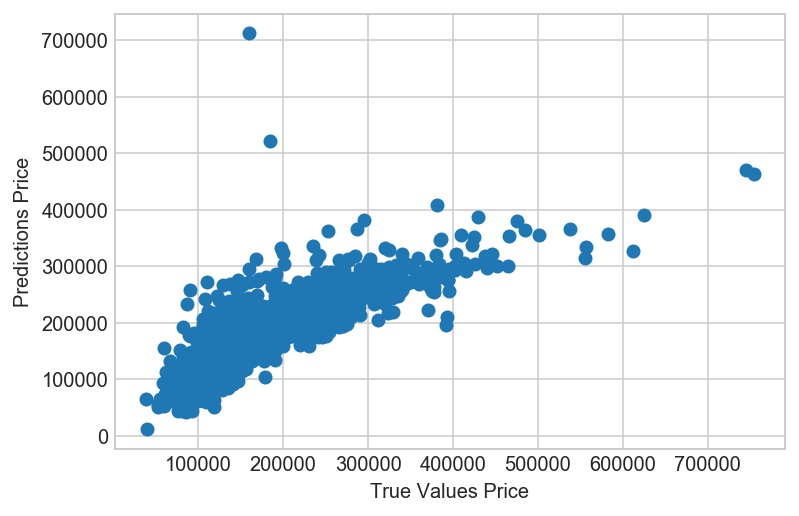

In [81]:
# Plotting original price and predicted price on X and Y axis of pot.
plt.scatter(y, yhat)
plt.xlabel("True Values Price")
plt.ylabel("Predictions Price")

In [151]:
# 4.Train a model on pre-2010 data and evaluate its performance on the 2010 houses
np.sort(df['YrSold'].unique()) # values range from 2006 till 2010
l2010 = df['YrSold'] < 2010 # 1278 Rows for less than 2010 year
e2010 = df['YrSold'] == 2010 # 172 Rows for equal to 2010 year

# Splitting data into test and train based on Year 2010

Xtrain = df[l2010] 
ytrain = Xtrain[['SalePrice']]
Xtrain = Xtrain[['1stFlrSF','GarageArea','GrLivArea','OverallQual']]
Xtrain = ss.fit_transform(Xtrain) # Standardize Xtrain

Xtest = df[e2010] 
ytest = Xtest[['SalePrice']]
Xtest = Xtest[['1stFlrSF','GarageArea','GrLivArea','OverallQual']]
Xtest = ss.fit_transform(Xtest) # Standardize Xtest


# Fitting a Liner model on X with standardization
linreg.fit(Xtrain,ytrain)  
yhat = linreg.predict(Xtest)
linreg.score(Xtest,ytest)
print ('Standard matrix score is : ', linreg.score(Xtest,ytest))

# Conclusion:  Model performed better score than before and now it is 0.7609

('Standard matrix score is : ', 0.76093242770641512)


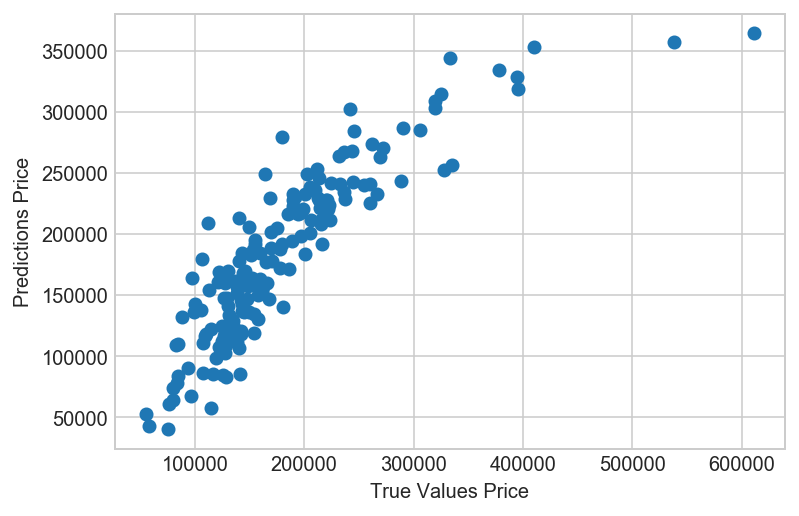

In [152]:
# Plotting original price and predicted price on X and Y axis of pot.
plt.scatter(ytest, yhat)
plt.xlabel("True Values Price")
plt.ylabel("Predictions Price")

In [ ]:
# To check if other variables need to be considered or not we will do Null analysis 
# and value count analysis.

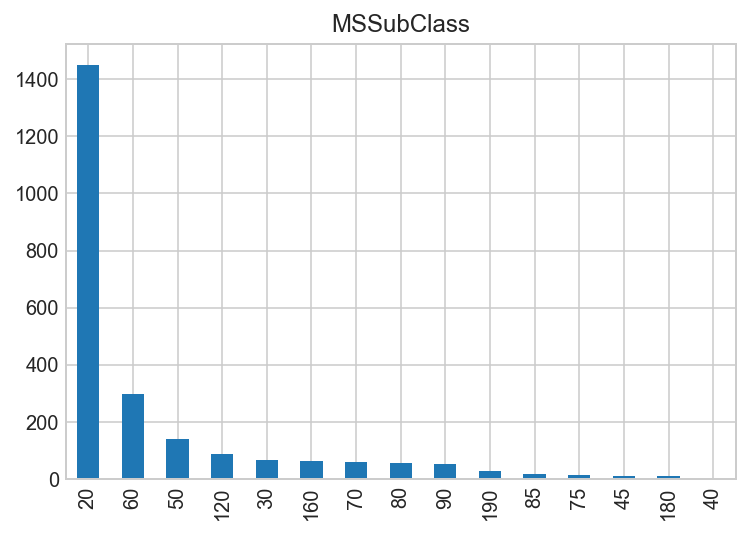

In [245]:
df_test = df[['Utilities','MSSubClass']]
df_test

for col in df_test.columns:
    df_test[col].value_counts().plot(kind='bar',title=col)


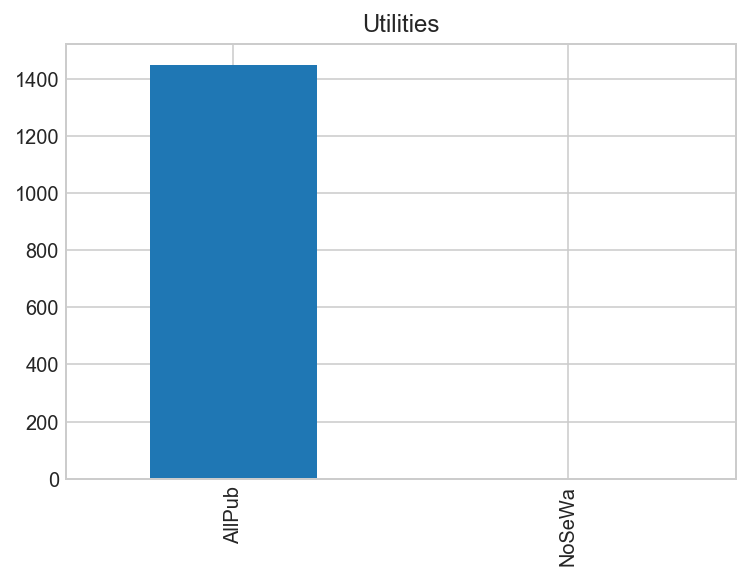

In [242]:
# Cell idea and code courtesy by Anuj

# df.Utilities.value_counts()
_=df['Utilities'].value_counts().plot(kind='bar',title='Utilities')
# df['Utilities'].value_counts()
# len(df['Utilities'].value_counts())

# df['MSSubClass'].value_counts()
# len(df['Utilities'].value_counts())


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: